In [1]:
import h5py
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np



def get_all_datasets(hdf_file):
    datasets = {}

    def collect_datasets(name, obj):
        if isinstance(obj, h5py.Dataset):
            datasets[name] = obj[:]

    hdf_file.visititems(collect_datasets)
    return datasets

def nice_dict_contents(data_dict, print_keys=False):
    outer_keys = {}
    for key in data_dict.keys():
        num_levels = len(key.split('/'))
        outer = key.split('/')[0]
        if num_levels == 2:
            inner = key.split('/')[1]
            if outer not in outer_keys.keys():
                outer_keys[outer] = []
            outer_keys[outer].append(inner)
        else:
            middle = key.split('/')[1]
            inner = key.split('/')[2]
            if outer not in outer_keys.keys():
                outer_keys[outer] = {}
            if middle not in outer_keys[outer].keys():
                outer_keys[outer][middle] = []
            outer_keys[outer][middle].append(inner)


    if print_keys:
        print('CONTENTS OF HDF5 FILE:')
        for key, v in outer_keys.items():
            print(key)
            if isinstance(v, list):
                #for i in v:
                print('\t', ', '.join(v))
            else:
                for k, v in v.items():
                    print('\t', k)
                    #for i in v:
                    print('\t\t', ', '.join(v))

def load_data(file_path='C:/Users/Chris Bhysicisd/Desktop/Applied machine learning/final project/a000_1/data.hdf5', verbose=False):
    with h5py.File(file_path, 'r') as hdf_file:
        data_dict = get_all_datasets(hdf_file)
    
    if verbose:
        nice_dict_contents(data_dict, print_keys=True)

    return data_dict


In [2]:

# Function definitions for get_all_datasets and nice_dict_contents

def load_data(file_path='C:/Users/Chris Bhysicisd/Desktop/Applied machine learning/final project/a000_1/data.hdf5', verbose=False):
    with h5py.File(file_path, 'r') as hdf_file:
        data_dict = get_all_datasets(hdf_file)
    
    if verbose:
        nice_dict_contents(data_dict, print_keys=True)

    return data_dict

# # Load the data_dict using the load_data function
data_dict = load_data('C:/Users/Chris Bhysicisd/Desktop/Applied machine learning/final project/a000_1/data.hdf5')

In [3]:
a = data_dict['pose/tango_ori']
b = data_dict['synced/acce']
c = data_dict['pose/tango_pos']


In [4]:
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Generate dummy IMU dataset
accelerometer_data = b  # Shape: (samples, 3)
tango_ori_data = a # Shape: (samples, 3)
positions = c  # Shape: (samples, 3)

In [5]:
b

array([[-9.70016929,  0.47133655, -0.4418631 ],
       [-9.6989351 ,  0.47302931, -0.44404597],
       [-9.68712597,  0.46807158, -0.45390556],
       ...,
       [-9.83743384,  0.5090351 ,  1.46733766],
       [-9.8120985 ,  0.5239982 ,  1.47054532],
       [-9.79265366,  0.53980524,  1.47635041]])

In [6]:
a

array([[ 0.34436653,  0.59040797,  0.35096438, -0.64004271],
       [ 0.34441047,  0.59042746,  0.35096543, -0.64000051],
       [ 0.34444966,  0.59044127,  0.35095287, -0.63997356],
       ...,
       [ 0.50364454, -0.51129683,  0.56506173,  0.40696871],
       [ 0.50353097, -0.51139132,  0.56512039,  0.40690905],
       [ 0.50341483, -0.51148041,  0.56518603,  0.40684961]])

In [7]:
data = np.concatenate((accelerometer_data, tango_ori_data), axis=1)  

In [8]:
data

array([[-9.70016929,  0.47133655, -0.4418631 , ...,  0.59040797,
         0.35096438, -0.64004271],
       [-9.6989351 ,  0.47302931, -0.44404597, ...,  0.59042746,
         0.35096543, -0.64000051],
       [-9.68712597,  0.46807158, -0.45390556, ...,  0.59044127,
         0.35095287, -0.63997356],
       ...,
       [-9.83743384,  0.5090351 ,  1.46733766, ..., -0.51129683,
         0.56506173,  0.40696871],
       [-9.8120985 ,  0.5239982 ,  1.47054532, ..., -0.51139132,
         0.56512039,  0.40690905],
       [-9.79265366,  0.53980524,  1.47635041, ..., -0.51148041,
         0.56518603,  0.40684961]])

In [9]:
# Convert the NumPy array into a pandas DataFrame
dfX = pd.DataFrame(data)
dfy = pd.DataFrame(c)

In [10]:
X = dfX
y = dfy

In [11]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)

X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2)

In [12]:
from sklearn.preprocessing import StandardScaler
from sklearn.compose import make_column_transformer
import pandas as pd

In [13]:
ct = make_column_transformer(
    (StandardScaler(), list(X.columns)),
    remainder='passthrough'
    )

ct.fit(X_train)
ct.transform(X_train)
ct.transform(X_test)
ct.transform(X_valid);

In [14]:
import tensorflow as tf
model = tf.keras.Sequential([
    tf.keras.layers.Dense(10,activation='relu'),
    tf.keras.layers.Dense(256,activation='relu'),
    tf.keras.layers.Dense(3, activation='linear')
])

In [15]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

In [16]:
model.compile(loss = tf.keras.losses.mean_absolute_error,
               optimizer = tf.keras.optimizers.Adam(lr=0.01),
               metrics=['mae'])
# Define the ReduceLROnPlateau callback
reduce_lr = ReduceLROnPlateau(factor=0.1, patience=5)

history = model.fit(X_train, y_train, epochs=40, validation_data=(X_valid,y_valid),callbacks=[reduce_lr])

Epoch 1/40


C:\Users\Chris Bhysicisd\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


1353/1353 [==============================] - 4s 2ms/step - loss: 5.6067 - mae: 5.6067 - val_loss: 5.0778 - val_mae: 5.0778 - lr: 0.0100
Epoch 2/40
1353/1353 [==============================] - 3s 2ms/step - loss: 4.9333 - mae: 4.9333 - val_loss: 4.8125 - val_mae: 4.8125 - lr: 0.0100
Epoch 3/40
1353/1353 [==============================] - 3s 2ms/step - loss: 4.6395 - mae: 4.6395 - val_loss: 4.6430 - val_mae: 4.6430 - lr: 0.0100
Epoch 4/40
1353/1353 [==============================] - 3s 2ms/step - loss: 4.4123 - mae: 4.4123 - val_loss: 4.3579 - val_mae: 4.3579 - lr: 0.0100
Epoch 5/40
1353/1353 [==============================] - 3s 2ms/step - loss: 4.2712 - mae: 4.2712 - val_loss: 4.1794 - val_mae: 4.1794 - lr: 0.0100
Epoch 6/40
1353/1353 [==============================] - 3s 2ms/step - loss: 4.2115 - mae: 4.2115 - val_loss: 4.1184 - val_mae: 4.1184 - lr: 0.0100
Epoch 7/40
1353/1353 [==============================] - 3s 2ms/step - loss: 4.1427 - mae: 4.1427 - val_loss: 4.0621 - val_mae: 4.

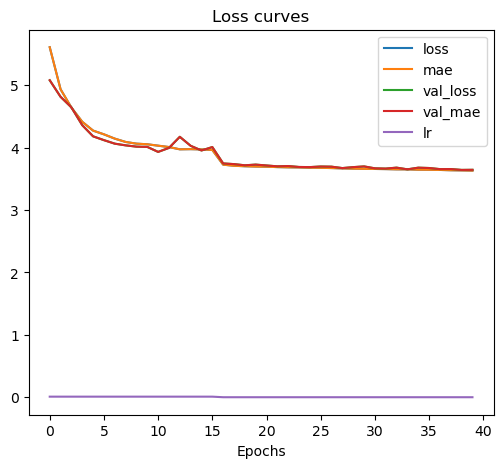

In [17]:
pd.DataFrame(history.history).plot(figsize=(6,5))
plt.xlabel("Epochs")
plt.title('Loss curves')
plt.legend();

423/423 [==============================] - 2s 4ms/step


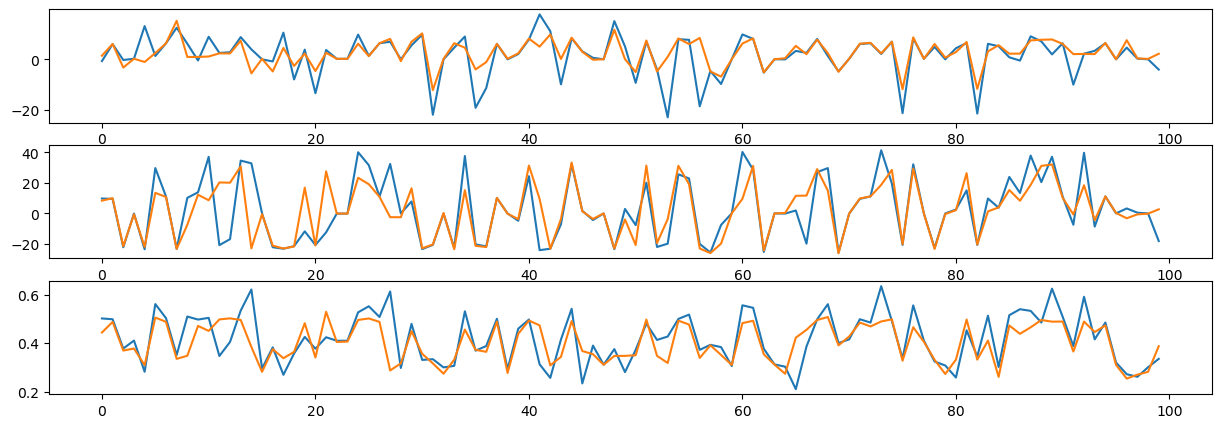

In [18]:
fig, ax = plt.subplots(3,1, figsize = (15,5))
N = 100
y_pred = model.predict(X_test)
for i in range(3):
    ax[i].plot(y_test.values[:N,i])
    ax[i].plot(y_pred[:N,i])

In [71]:
import h5py
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np



def load_much_data(N_train, N_test, folder_path, columns_X, columns_y, seq_length=1, verbose=False, num_datasets=1, random_start=False):
    """
    Function to load data from multiple HDF5 files.

    Args:
    Ntrain : int
        Number of training instances.
    Nval : int
        Number of validation instances.
    folder_path : str
        Path to the data directory.
    columns : list
        List of column names.

    Returns:
    data_dict : dict
        Dictionary with dataset names as keys and numpy arrays as values.
    """
    data = {
        'X-train': {key: None for key in columns_X},
        'y-train': {key: None for key in columns_y},
        'X-test': {key: None for key in columns_X},
        'y-test': {key: None for key in columns_y},
    }
    Nloaded_points = 0
    # get control of directories
    dirs = os.listdir(folder_path)
    if '.DS_Store' in dirs: dirs.remove('.DS_Store') # remove .DS_Store if present
    test_dir = dirs[:1]
    train_dirs = dirs[1:num_datasets+1]
    print(f'using {test_dir} for testing and the remaining ({len(train_dirs)}) for training')
    

    N_points_per_dir = max(int(N_train/len(train_dirs)), seq_length)
    N_points_per_dir = N_points_per_dir - N_points_per_dir % seq_length
    n_dirs_to_use = int(N_train/N_points_per_dir)
    train_dirs = train_dirs[:n_dirs_to_use+1]
    N_points = N_points_per_dir * len(train_dirs)
    
    print(f'Loading a total of {N_train}, with {N_points_per_dir} points from each of {len(train_dirs)} directories')
    for dir in dirs:
        file_path = os.path.join(folder_path, dir, 'data.hdf5')
        if verbose: print('Loading file:', file_path)
        with h5py.File(file_path, "r") as hdf_file:
            new_data_dict = load_data(file_path)
            Nloaded_points += N_points_per_dir
        if dir in test_dir:
            start = 0 if not random_start else np.random.randint(0, 20000)
            for key in columns_X:
                if data['X-test'][key] is None:
                    data['X-test'][key] = new_data_dict[key][start:start+N_test]
                else:
                    data['X-test'][key] = np.vstack([data['X-test'][key], new_data_dict[key][:N_test]])
            for key in columns_y:
                if data['y-test'][key] is None:
                    data['y-test'][key] = new_data_dict[key][start:start+N_test]
                else:
                    data['y-test'][key] = np.vstack([data['y-test'][key], new_data_dict[key][:N_test]])
        elif dir in train_dirs:
            for key in columns_X:
                if data['X-train'][key] is None:
                    data['X-train'][key] = new_data_dict[key][start:start+N_points_per_dir]
                else:
                    data['X-train'][key] = np.vstack([data['X-train'][key], new_data_dict[key][:N_points_per_dir]])
            for key in columns_y:
                if data['y-train'][key] is None:
                    data['y-train'][key] = new_data_dict[key][start:start+N_points_per_dir]
                else:
                    data['y-train'][key] = np.vstack([data['y-train'][key], new_data_dict[key][:N_points_per_dir]])
        if Nloaded_points >= N_points:
            break

    return data

In [72]:
folder_path = 'C:/Users/Chris Bhysicisd/Desktop/Applied machine learning/final project/datasets/Dataset 1'

In [73]:
Ntrain = 75000
Ntest = 25000
columns_X = ['pose/tango_ori' , 'synced/acce']
columns_y = ['pose/tango_pos']
seq_length=1
verbose=False
num_datasets=5
random_start=False

In [74]:
  params = {'N_train': Ntrain, 
               'N_test': Ntest,
               'columns_X' : columns_X,
               'columns_y' : columns_y,
               'seq_length': seq_length, 
               'verbose': False, 'num_datasets':num_datasets,
               'random_start':random_start,
               }

In [75]:
import os
data = load_much_data(folder_path=folder_path, **params)

using ['a000_1'] for testing and the remaining (5) for training
Loading a total of 75000, with 15000 points from each of 5 directories


In [76]:
data

{'X-train': {'pose/tango_ori': array([[ 0.55092958,  0.48476543,  0.46269514, -0.497386  ],
         [ 0.55095712,  0.48475588,  0.46268174, -0.49737725],
         [ 0.55099131,  0.48473399,  0.46266642, -0.49737497],
         ...,
         [ 0.40898312,  0.58862729,  0.41495481, -0.56041302],
         [ 0.41011255,  0.58803002,  0.41554633, -0.55977599],
         [ 0.41124103,  0.58743044,  0.41613752, -0.55913807]]),
  'synced/acce': array([[-9.84701283, -0.85775104, -0.98330132],
         [-9.84385864, -0.86169483, -1.00000386],
         [-9.86896548, -0.803299  , -1.00676337],
         ...,
         [-7.36414618, -7.18058849,  0.46110835],
         [-7.43890646, -7.1483128 ,  0.50672094],
         [-7.50202427, -6.94777464,  0.56611501]])},
 'y-train': {'pose/tango_pos': array([[-1.50901492e-02,  1.69271899e-02, -3.95125726e-02],
         [-1.51111942e-02,  1.70681529e-02, -3.95162749e-02],
         [-1.51307102e-02,  1.72108016e-02, -3.95222404e-02],
         ...,
         [-1.450

In [77]:
X_train = data['X-train']['pose/tango_ori']
X_train2 = data['X-train']['synced/acce']
X_test = data['X-test']['pose/tango_ori']
X_test2 = data['X-test']['synced/acce']
y_test = data['y-test']['pose/tango_pos']
y_train = data['y-train']['pose/tango_pos']

In [78]:
X_train.shape

(60000, 4)

In [79]:
X_train2.shape

(60000, 3)

In [80]:
d = np.concatenate((X_train, X_test), axis=0)

In [81]:
d.shape

(85000, 4)

In [82]:
e = np.concatenate((X_train2, X_test2), axis=0)

In [83]:
e.shape

(85000, 3)

In [84]:
ff = np.concatenate((e,d), axis =1)

In [85]:
ff

array([[-9.84701283, -0.85775104, -0.98330132, ...,  0.48476543,
         0.46269514, -0.497386  ],
       [-9.84385864, -0.86169483, -1.00000386, ...,  0.48475588,
         0.46268174, -0.49737725],
       [-9.86896548, -0.803299  , -1.00676337, ...,  0.48473399,
         0.46266642, -0.49737497],
       ...,
       [ 2.10015795,  9.44203831,  3.88946522, ...,  0.62803394,
        -0.23081349, -0.72984241],
       [ 2.17791303,  9.40251112,  3.94928503, ...,  0.62775609,
        -0.22942652, -0.73066877],
       [ 2.28565101,  9.3782083 ,  4.01357517, ...,  0.62754656,
        -0.22801986, -0.73144731]])

In [86]:
f = np.concatenate((y_test, y_train), axis=0)  

In [87]:
f

array([[ 0.04820056,  0.04020005,  0.31133411],
       [ 0.04822482,  0.04023623,  0.31135088],
       [ 0.04824895,  0.04027329,  0.3113661 ],
       ...,
       [-1.45020364, 32.37758217,  0.54125501],
       [-1.45086096, 32.38096247,  0.54096531],
       [-1.45151831, 32.38434287,  0.54067561]])

In [88]:
X_many = pd.DataFrame(ff)
y_many = pd.DataFrame(f)

In [89]:
X = X_many
y = y_many

In [90]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)

X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2)

In [91]:
from sklearn.preprocessing import StandardScaler
from sklearn.compose import make_column_transformer


In [92]:
ct = make_column_transformer(
    (StandardScaler(), list(X.columns)),
    remainder='passthrough'
    )

ct.fit(X_train)
ct.transform(X_train)
ct.transform(X_test)
ct.transform(X_valid);

In [93]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)

X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2)

In [94]:
from sklearn.preprocessing import StandardScaler
from sklearn.compose import make_column_transformer
import pandas as pd

In [95]:
ct = make_column_transformer(
    (StandardScaler(), list(X.columns)),
    remainder='passthrough'
    )

ct.fit(X_train)
ct.transform(X_train)
ct.transform(X_test)
ct.transform(X_valid);

In [96]:
# Generate a prediction using model.predict() 
# and calculate it's shape:
print("Generate a prediction")
prediction = model.predict(X_test[:1])
print("prediction shape:", prediction.shape)

Generate a prediction
1/1 [==============================] - 0s 26ms/step
prediction shape: (1, 3)


532/532 [==============================] - 1s 2ms/step


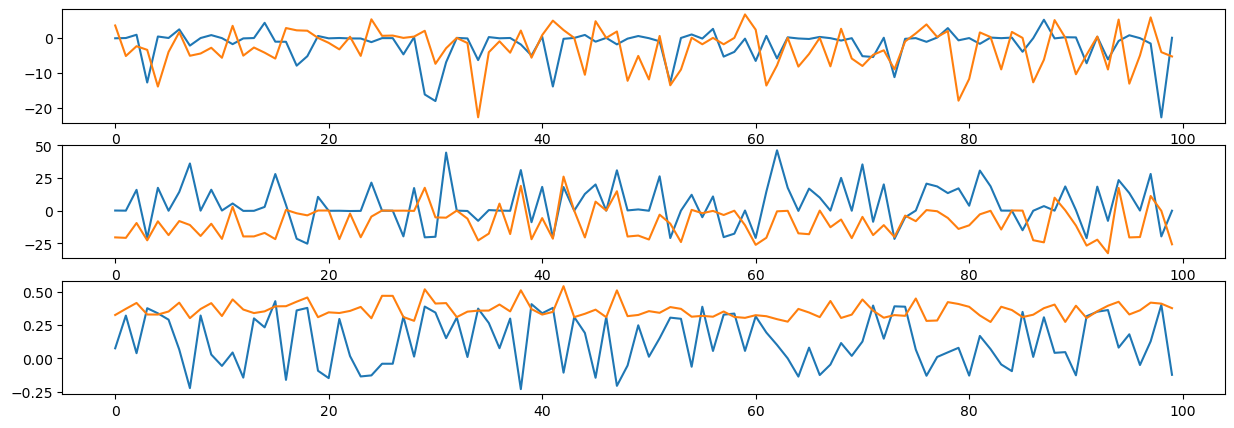

In [97]:
fig, ax = plt.subplots(3,1, figsize = (15,5))
N = 100
y_pred = model.predict(X_test)
for i in range(3):
    ax[i].plot(y_test.values[:N,i])
    ax[i].plot(y_pred[:N,i])